In [1]:
import numpy as np
from qiskit import BasicAer, IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.aqua.components.oracles import CustomCircuitOracle, LogicalExpressionOracle
from qiskit.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from matplotlib import pyplot as plt


In [2]:
variable_qubits = QuantumRegister(3, name='v')
clause_qubits = QuantumRegister(3, name='c')
output_qubits = QuantumRegister(1, name='o')
# variable_qubits = QuantumRegister(2, name='v')
# clause_qubits = QuantumRegister(2, name='c')
# output_qubits = QuantumRegister(1, name='o')
qc = QuantumCircuit(variable_qubits, clause_qubits, output_qubits)



In [3]:

# (v1 V ¬v2 V v3) ∧  (v1 V ¬3) ∧ (¬v1 V v2)  ==
# ¬(¬v1 ∧ v2 ∧ ¬v3) ∧ ¬(¬v1 ∧ v3) ∧ ¬(v1 ∧ ¬v2) 



def process_oracle(qc,variable_qubits,clause_qubits,output_qubits):
    qc.x(clause_qubits) #all of them are inversed

    qc.x(variable_qubits[0]) #fisrt clause
    qc.x(variable_qubits[1]) #(¬v1 ∧ ¬v2 ∧ v3)
    qc.mcx(variable_qubits, clause_qubits[0])

    qc.x(variable_qubits[1]) 
    qc.x(variable_qubits[2]) #(¬v1 ∧ v2 ∧ ¬v3)
    qc.mcx(variable_qubits, clause_qubits[1])

    qc.x(variable_qubits[0]) #third clause
    qc.x(variable_qubits[2]) #(v1 ∧ v2 ∧ v3)
    qc.mcx(variable_qubits, clause_qubits[2])

def unprocess_oracle(qc,variable_qubits,clause_qubits,output_qubits):
    qc.x(variable_qubits[0]) #third clause
    qc.x(variable_qubits[2]) #(v1 ∧ v2 ∧ v3)
    qc.mcx(variable_qubits, clause_qubits[2])

    qc.x(variable_qubits[1]) 
    qc.x(variable_qubits[2]) #(¬v1 ∧ v2 ∧ ¬v3)
    qc.mcx(variable_qubits, clause_qubits[1])

    qc.x(variable_qubits[0]) #fisrt clause
    qc.x(variable_qubits[1]) #(¬v1 ∧ ¬v2 ∧ v3)
    qc.mcx(variable_qubits, clause_qubits[0])

    qc.x(clause_qubits) #all of them are inversed
    
process_oracle(qc,variable_qubits,clause_qubits,output_qubits)
qc.mcp(-1,clause_qubits,output_qubits)
unprocess_oracle(qc,variable_qubits,clause_qubits,output_qubits) #reverse
qc.draw()

┌───┐               ┌───┐       ┌───┐                      ┌───┐     
v_0: ┤ X ├──■─────────■──┤ X ├──■────┤ X ├─────────■─────────■──┤ X ├──■──
     ├───┤  │  ┌───┐  │  └───┘  │    └───┘         │  ┌───┐  │  ├───┤  │  
v_1: ┤ X ├──■──┤ X ├──■─────────■──────────────────■──┤ X ├──■──┤ X ├──■──
     └───┘  │  ├───┤  │  ┌───┐  │    ┌───┐         │  ├───┤  │  └───┘  │  
v_2: ───────■──┤ X ├──■──┤ X ├──■────┤ X ├─────────■──┤ X ├──■─────────■──
     ┌───┐┌─┴─┐└───┘  │  └───┘  │    └───┘  ┌───┐  │  └───┘  │       ┌─┴─┐
c_0: ┤ X ├┤ X ├───────┼─────────┼──────■────┤ X ├──┼─────────┼───────┤ X ├
     ├───┤└───┘     ┌─┴─┐       │      │    ├───┤  │       ┌─┴─┐     └───┘
c_1: ┤ X ├──────────┤ X ├───────┼──────■────┤ X ├──┼───────┤ X ├──────────
     ├───┤          └───┘     ┌─┴─┐    │    ├───┤┌─┴─┐     └───┘          
c_2: ┤ X ├────────────────────┤ X ├────■────┤ X ├┤ X ├────────────────────
     └───┘                    └───┘┌───┴───┐└───┘└───┘                    
o_0: ──────────────────────────────┤ P(-1) ├──────────────────────────────
                                   └───────┘

In [4]:
qc.x(variable_qubits[1])
qc.mcx(variable_qubits,clause_qubits[0])
qc.x(variable_qubits)
qc.mcx(variable_qubits,clause_qubits[1])

qc.mcx(clause_qubits, output_qubits)

qc.x(variable_qubits[1])
qc.mcx(variable_qubits,clause_qubits[0])
qc.x(variable_qubits)
qc.mcx(variable_qubits,clause_qubits[1])

qc.draw()

┌───┐               ┌───┐       ┌───┐                      ┌───┐          »
v_0: ┤ X ├──■─────────■──┤ X ├──■────┤ X ├─────────■─────────■──┤ X ├──■───────»
     ├───┤  │  ┌───┐  │  └───┘  │    └───┘         │  ┌───┐  │  ├───┤  │  ┌───┐»
v_1: ┤ X ├──■──┤ X ├──■─────────■──────────────────■──┤ X ├──■──┤ X ├──■──┤ X ├»
     └───┘  │  ├───┤  │  ┌───┐  │    ┌───┐         │  ├───┤  │  └───┘  │  └───┘»
v_2: ───────■──┤ X ├──■──┤ X ├──■────┤ X ├─────────■──┤ X ├──■─────────■───────»
     ┌───┐┌─┴─┐└───┘  │  └───┘  │    └───┘  ┌───┐  │  └───┘  │       ┌─┴─┐     »
c_0: ┤ X ├┤ X ├───────┼─────────┼──────■────┤ X ├──┼─────────┼───────┤ X ├─────»
     ├───┤└───┘     ┌─┴─┐       │      │    ├───┤  │       ┌─┴─┐     └───┘     »
c_1: ┤ X ├──────────┤ X ├───────┼──────■────┤ X ├──┼───────┤ X ├───────────────»
     ├───┤          └───┘     ┌─┴─┐    │    ├───┤┌─┴─┐     └───┘               »
c_2: ┤ X ├────────────────────┤ X ├────■────┤ X ├┤ X ├─────────────────────────»
     └───┘                    └───┘┌───┴───┐└───┘└───┘                         »
o_0: ──────────────────────────────┤ P(-1) ├───────────────────────────────────»
                                   └───────┘                                   »
«          ┌───┐               ┌───┐     
«v_0: ──■──┤ X ├──■─────────■──┤ X ├──■──
«       │  ├───┤  │  ┌───┐  │  ├───┤  │  
«v_1: ──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
«       │  ├───┤  │  └───┘  │  ├───┤  │  
«v_2: ──■──┤ X ├──■─────────■──┤ X ├──■──
«     ┌─┴─┐└───┘  │       ┌─┴─┐└───┘  │  
«c_0: ┤ X ├───────┼────■──┤ X ├───────┼──
«     └───┘     ┌─┴─┐  │  └───┘     ┌─┴─┐
«c_1: ──────────┤ X ├──■────────────┤ X ├
«               └───┘  │            └───┘
«c_2: ─────────────────■─────────────────
«                    ┌─┴─┐               
«o_0: ───────────────┤ X ├───────────────
«                    └───┘

In [5]:
#(v1 V ¬v2 V v3) ∧ (v1 V ¬3) ∧ (¬v1 V v2) 
expression = '''
c example DIMACS-CNF 3-SAT
p cnf 3 3
-1 -2 3 0
1 -2 -3 0
1 2 3 0
'''
a = LogicalExpressionOracle(expression)
print(a.circuit)

     ┌───┐      ┌───┐┌───┐      ┌───┐      ┌───┐            ┌───┐┌───┐      »
v_0: ┤ X ├──■───┤ X ├┤ X ├──■───┤ X ├──■───┤ X ├────────■───┤ X ├┤ X ├──■───»
     ├───┤  │   ├───┤└───┘  │   └───┘  │   ├───┤        │   ├───┤└───┘  │   »
v_1: ┤ X ├──■───┤ X ├───────■──────────■───┤ X ├────────■───┤ X ├───────■───»
     ├───┤  │   ├───┤       │   ┌───┐  │   ├───┤ ┌───┐  │   ├───┤       │   »
v_2: ┤ X ├──■───┤ X ├───────■───┤ X ├──■───┤ X ├─┤ X ├──■───┤ X ├───────■───»
     ├───┤┌─┴──┐└───┘       │   └───┘  │   └───┘ ├───┤┌─┴──┐└───┘       │   »
c_0: ┤ X ├┤0   ├────────────┼──────────┼─────■───┤ X ├┤0   ├────────────┼───»
     ├───┤│    │          ┌─┴──┐       │     │   ├───┤│    │          ┌─┴──┐»
c_1: ┤ X ├┤    ├──────────┤0   ├───────┼─────■───┤ X ├┤    ├──────────┤0   ├»
     ├───┤│    │          │    │     ┌─┴──┐  │   ├───┤│    │          │    │»
c_2: ┤ X ├┤  X ├──────────┤    ├─────┤0   ├──■───┤ X ├┤  X ├──────────┤    ├»
     └───┘│    │          │  X │     │    │┌─┴──┐└───┘│    │    

In [6]:
expressionClass = LogicalExpressionOracle(expression)
oracle = CustomCircuitOracle(variable_qubits, output_qubits, qc, evaluate_classically_callback=expressionClass.evaluate_classically)
print(oracle.construct_circuit())

     ┌───┐               ┌───┐       ┌───┐                      ┌───┐          »
v_0: ┤ X ├──■─────────■──┤ X ├──■────┤ X ├─────────■─────────■──┤ X ├──■───────»
     ├───┤  │  ┌───┐  │  └───┘  │    └───┘         │  ┌───┐  │  ├───┤  │  ┌───┐»
v_1: ┤ X ├──■──┤ X ├──■─────────■──────────────────■──┤ X ├──■──┤ X ├──■──┤ X ├»
     └───┘  │  ├───┤  │  ┌───┐  │    ┌───┐         │  ├───┤  │  └───┘  │  └───┘»
v_2: ───────■──┤ X ├──■──┤ X ├──■────┤ X ├─────────■──┤ X ├──■─────────■───────»
     ┌───┐┌─┴─┐└───┘  │  └───┘  │    └───┘  ┌───┐  │  └───┘  │       ┌─┴─┐     »
c_0: ┤ X ├┤ X ├───────┼─────────┼──────■────┤ X ├──┼─────────┼───────┤ X ├─────»
     ├───┤└───┘     ┌─┴─┐       │      │    ├───┤  │       ┌─┴─┐     └───┘     »
c_1: ┤ X ├──────────┤ X ├───────┼──────■────┤ X ├──┼───────┤ X ├───────────────»
     ├───┤          └───┘     ┌─┴─┐    │    ├───┤┌─┴─┐     └───┘               »
c_2: ┤ X ├────────────────────┤ X ├────■────┤ X ├┤ X ├─────────────────────────»
     └───┘                  

In [10]:
expressionClass = LogicalExpressionOracle(expression)
oracle = CustomCircuitOracle(variable_qubits, output_qubits, qc, evaluate_classically_callback=expressionClass.evaluate_classically)

# grover = Grover(a)
grover = Grover(oracle)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])

[-1, 2, -3]
/home/teyal/.cache/pypoetry/virtualenvs/oraculo-TgiV9kYS-py3.9/lib/python3.9/site-packages/qiskit/aqua/algorithms/amplitude_amplifiers/grover.py:608: DeprecationWarning: result deprecated, use assignment property.
  warnings.warn('result deprecated, use assignment property.', DeprecationWarning)


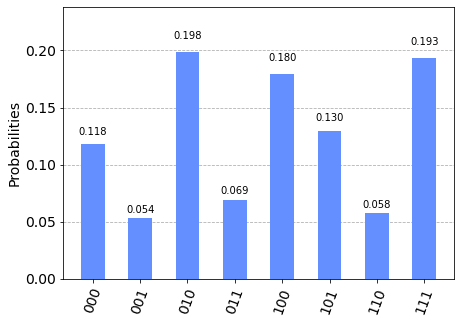

In [11]:
plot_histogram(result['measurement'])

In [9]:
## ¬(¬v1 ∧ ¬v2 ∧ v3) V ¬(¬v1 ∧ v2 ∧ ¬v3) V ¬(v1 ∧ v2 ∧ v3)